In [ ]:
%load_ext autoreload
%autoreload 2

from funcs import *
import geopandas as gpd
import pandas as pd
import numpy as np
from api import get_data
import json

import contextily as cx

from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx

# Get the counties and cities in the DC area
fips_df = pd.read_csv("data/state_and_county_fips_master.csv")
fips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]
fips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])
dc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]
md_counties = ["Prince George's County", "Montgomery County"]
va_counties = ["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city"]
md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(md_counties)]["code"] # , "Anne Arundel County", "Howard County", "Baltimore County", "Baltimore city"
va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(va_counties)]["code"] # , "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"
dcs_df = gpd.GeoDataFrame.from_file("data/real_transit/DC_Streetcar_Routes.shp").to_crs("EPSG:4326")
dcs_df.color = 'brown'
# get existing transit lines
marc_df = gpd.GeoDataFrame.from_file("data/real_transit/Maryland_Transit_-_MARC_Train_Lines.shp").to_crs("EPSG:4326")
marc_df["color"] = marc_df["Rail_Name"].apply(lambda a: '#EFAD1D' if 'Brunswick' in a else '#F15828' if 'Camden' in a else '#C71F3E')
wmata_df = gpd.GeoDataFrame.from_file("data/real_transit/Metro_Lines_Regional.shp").to_crs("EPSG:4326")
wmata_df["color"] = wmata_df["NAME"].apply(lambda a: 
    '#F9921D' if 'orange' in a else 
    '#A1A3A1' if 'silver' in a else 
    '#E41838' if 'red' in a else
    '#FED201' if 'yellow' in a else
    '#01A850' if 'green' in a else
   '#0077C1')
vre_df = gpd.GeoDataFrame.from_file("data/real_transit/Virginia_Railway_Express_Routes.shp").to_crs("EPSG:4326")
vre_df["color"] = vre_df["RAILWAY_NM"].apply(lambda a: 
    '#156DB4' if 'Manassas' in a else 
    '#DD3534')
pl_df = gpd.GeoDataFrame.from_file("data/real_transit/PurpleLineAlignment.shp").to_crs("EPSG:4326")
pl_df["color"] = "#793390"
# Get census data
md_df = gpd.read_file("data/md/tl_2023_24_tabblock20.shp")
md_df = md_df[md_df["COUNTYFP20"].isin(md_codes.to_list())]
va_df = gpd.read_file("data/va/tl_2023_51_tabblock20.shp")
va_df = va_df[va_df["COUNTYFP20"].isin(va_codes.to_list())]

dc_df = gpd.read_file("data/dc/tl_2023_11_tabblock20.shp")

df = pd.concat([md_df, va_df, dc_df])
df.index = np.arange(df.shape[0])
df = gpd.GeoDataFrame(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\srjnk\AppData\Local\Temp\ipykernel_17088\1213225491.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(md_counties)]["code"] # , "Anne Arundel County", "Howard County", "Baltimore County", "Baltimore city"
C:\Users\srjnk\AppData\Local\Temp\ipykernel_17088\1213225491.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(va_counties)]["code"] # , "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"


In [ ]:
df.to_crs("EPSG:4326",inplace=True)
df["SID"] = df.index
df["INTPTLON20"] = df["INTPTLON20"].apply(lambda a: float(a))
df["INTPTLAT20"] = df["INTPTLAT20"].apply(lambda a: float(a))
# add NEIGHBORS column
df["NEIGHBORS"] = None
df["transit_potential"] = np.log(df['POP20']/(df['ALAND20'] + df['AWATER20'])*1000 + 1)
df.to_file("data/complete_region_df.geojson", driver="GeoJSON")

df = gpd.GeoDataFrame.from_file("data/complete_region_df.geojson")
extremities = [df["INTPTLON20"].min(), df["INTPTLAT20"].min(), df["INTPTLON20"].max(), df["INTPTLAT20"].max()]
extremities_dc = [dc_df["INTPTLON20"].min(), dc_df["INTPTLAT20"].min(), dc_df["INTPTLON20"].max(), dc_df["INTPTLAT20"].max()]
df_map = df.to_crs(epsg=3857)
ex_map = [df_map.centroid.x.min(),df_map.centroid.y.min(),df_map.centroid.x.max(),df_map.centroid.y.max()]
df_map_dc = dc_df.to_crs(epsg=3857)
ex_map_dc = [df_map_dc.centroid.x.min(),df_map_dc.centroid.y.min(),df_map_dc.centroid.x.max(),df_map_dc.centroid.y.max()]

In [ ]:
df["point_likelihood"] = df["transit_potential"]
l = list(set(get_points(df, extremities)))
points = gpd.GeoDataFrame(df[df['SID'].isin(l)])
points.to_file("data/graph_points.geojson", driver="GeoJSON")
points = gpd.GeoDataFrame.from_file("data/graph_points.geojson")
combined_df_dc = gpd.GeoDataFrame.from_file("data/dc/non-population-points/combined_df.geojson")
combined_df_dc.reset_index(inplace=True, drop=True)
combined_df_md = gpd.GeoDataFrame.from_file("data/md/non-population-points/combined_df.geojson")
combined_df_md.reset_index(inplace=True, drop=True)
points = pd.concat([points, combined_df_dc, combined_df_md])
points.reset_index(inplace=True)
points = points["geometry"]
df_points = gpd.GeoDataFrame(geometry=points.centroid)
df_points = df_points.drop_duplicates()
df_points.reset_index(inplace=True, drop=True)
df_points = df_points.to_crs(3857)

C:\Users\srjnk\AppData\Local\Temp\ipykernel_17088\3048537429.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points = gpd.GeoDataFrame(geometry=points.centroid)


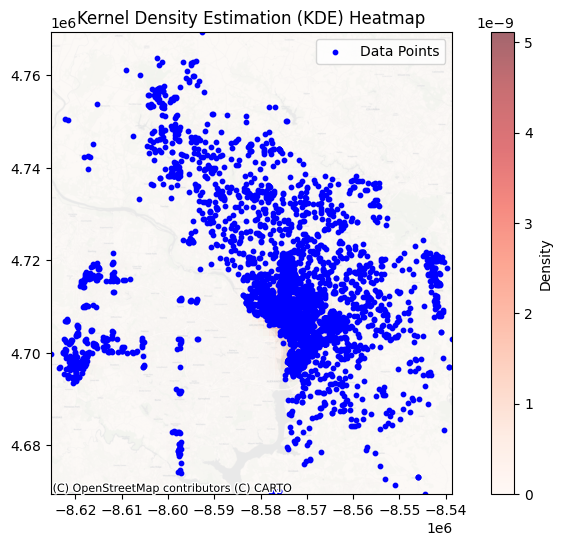

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KernelDensity
import contextily as cx

# Project points to Web Mercator for contextily compatibility
df_points_web = df_points.to_crs(epsg=3857)
coords_web = np.vstack([df_points_web.geometry.x, df_points_web.geometry.y]).T

# Compute KDE in Web Mercator coordinates
kde = KernelDensity(bandwidth=2000, kernel='gaussian')
kde.fit(coords_web)

# Define grid for density estimation
minx, miny, maxx, maxy = df_points_web.total_bounds
x_grid = np.linspace(minx, maxx, 70)
y_grid = np.linspace(miny, maxy, 70)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([xx.ravel(), yy.ravel()]).T

# Compute density estimates
log_dens = kde.score_samples(grid_coords)
density = np.exp(log_dens).reshape(xx.shape)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
# KDE heatmap
ax.imshow(
    np.flipud(density),
    extent=[minx, maxx, miny, maxy],
    cmap='Reds',
    alpha=0.6
)
# Plot points
df_points_web.plot(ax=ax, color='blue', markersize=10, label='Data Points')
# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=3857, zoom=12, alpha=0.5)
plt.colorbar(ax.images[0], label='Density')
plt.title('Kernel Density Estimation (KDE) Heatmap')
plt.legend()
plt.show()

In [34]:
pts_array = np.array(list(zip(df_points.geometry.x, df_points.geometry.y)))
gabriel = weights.Gabriel.from_dataframe(df_points, use_index=True,silence_warnings=True)
network = gabriel.to_networkx()
gabriel_contracted, new_positions = contract_louvain_communities_with_positions(
    network, 
    {n: pts_array[n] for n in network.nodes()}, 
    5
)
assign_edge_weights(gabriel_contracted, new_positions)
mst_contracted = reduce_degree(gabriel_contracted, new_positions, 4, 30)#nx.algorithms.tree.mst.minimum_spanning_tree(gabriel_contracted)
mst_contracted = remove_isolated_nodes(mst_contracted)
#coordinates = np.column_stack((df_points.geometry.x, df_points.geometry.y))
#positions = dict(zip(mst.nodes, coordinates))

c:\Users\srjnk\Documents\cmsc725_wmata_map\venv\Lib\site-packages\libpysal\weights\gabriel.py:145: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  return cls(point_array, ids=ids, **kwargs)


In [36]:
lines = perform_walks(mst_contracted, new_positions, num_walks=12, max_distance=200000)

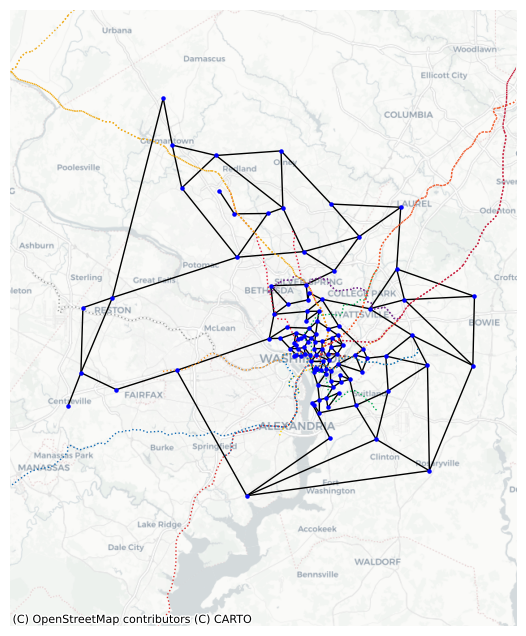

In [37]:
#ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
ax = wmata_df.to_crs(epsg=3857).plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
ax = pl_df.to_crs(epsg=3857).plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
ax = marc_df.to_crs(epsg=3857).plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
ax = vre_df.to_crs(epsg=3857).plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
ax = dcs_df.to_crs(epsg=3857).plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
#f,ax = mst.plot(df.to_crs(epsg=3857), ax=ax,
#        edge_kws=dict(color='r', linewidth=1.2),
#        node_kws=dict(marker=''))
ax.set_xlim([ex_map[0],ex_map[2]])
ax.set_ylim([ex_map[1],ex_map[3]])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax = nx.draw(mst_contracted, new_positions, ax=ax, node_size=5, node_color="b", edge_color="black")
#ax = plot_walks(mst_contracted, new_positions, lines, ax)
#ax = df_points.plot(ax=ax, color='black', marker='*', zorder=100)
plt.savefig("network_map_mst")

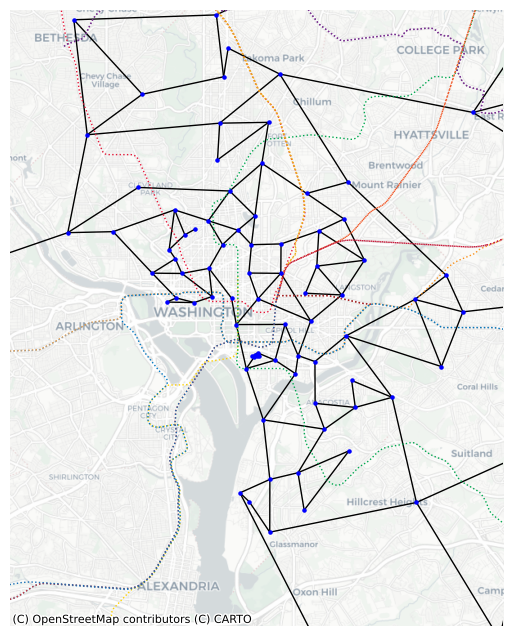

In [38]:
ax = wmata_df.to_crs(epsg=3857).plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
ax = pl_df.to_crs(epsg=3857).plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
ax = marc_df.to_crs(epsg=3857).plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
ax = vre_df.to_crs(epsg=3857).plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
ax = dcs_df.to_crs(epsg=3857).plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
#f,ax = mst.plot(df.to_crs(epsg=3857), ax=ax,
#        edge_kws=dict(color='r', linewidth=1.2),
#        node_kws=dict(marker=''))
#ax = df_points.plot(ax=ax, color='black', marker='*', zorder=100)
ax.set_xlim([ex_map_dc[0],ex_map_dc[2]])
ax.set_ylim([ex_map_dc[1],ex_map_dc[3]])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax = nx.draw(mst_contracted, new_positions, ax=ax, node_size=5, node_color="b", edge_color="black")
#ax = plot_walks(mst_contracted, new_positions, lines, ax)
plt.savefig("network_map_dc_mst")